In [1]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support

In [2]:
# Load and preprocess data
data = pd.read_csv('/content/data.csv')
values = data['value'].values.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_values = scaler.fit_transform(values)

In [3]:
# Prepare data for CNN
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back):
        X.append(dataset[i:(i+look_back), 0])
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 50  # History window size
X, Y = create_dataset(scaled_values, look_back)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

In [4]:
# Define the CNN model
model = Sequential()
model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(look_back, 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_absolute_error')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [5]:
# Train the model
model.fit(X, Y, epochs=50, batch_size=32, validation_split=0.2, verbose=2)

Epoch 1/50
24/24 - 7s - 284ms/step - loss: 0.1034 - val_loss: 0.0918
Epoch 2/50
24/24 - 5s - 204ms/step - loss: 0.0715 - val_loss: 0.0868
Epoch 3/50
24/24 - 0s - 14ms/step - loss: 0.0466 - val_loss: 0.0706
Epoch 4/50
24/24 - 0s - 8ms/step - loss: 0.0416 - val_loss: 0.0827
Epoch 5/50
24/24 - 0s - 15ms/step - loss: 0.0382 - val_loss: 0.0656
Epoch 6/50
24/24 - 0s - 10ms/step - loss: 0.0351 - val_loss: 0.0467
Epoch 7/50
24/24 - 0s - 7ms/step - loss: 0.0329 - val_loss: 0.0398
Epoch 8/50
24/24 - 0s - 13ms/step - loss: 0.0309 - val_loss: 0.0445
Epoch 9/50
24/24 - 0s - 9ms/step - loss: 0.0312 - val_loss: 0.0416
Epoch 10/50
24/24 - 0s - 4ms/step - loss: 0.0298 - val_loss: 0.0418
Epoch 11/50
24/24 - 0s - 3ms/step - loss: 0.0304 - val_loss: 0.0501
Epoch 12/50
24/24 - 0s - 3ms/step - loss: 0.0364 - val_loss: 0.0505
Epoch 13/50
24/24 - 0s - 3ms/step - loss: 0.0305 - val_loss: 0.0423
Epoch 14/50
24/24 - 0s - 6ms/step - loss: 0.0303 - val_loss: 0.0387
Epoch 15/50
24/24 - 0s - 5ms/step - loss: 0.0290 

In [6]:
# Predict and calculate reconstruction error
predictions = model.predict(X)
reconstruction_error = np.abs(predictions.flatten() - Y.flatten())

30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


In [7]:
# Define the threshold for anomaly detection
mean_error = np.mean(reconstruction_error)
std_error = np.std(reconstruction_error)
threshold = mean_error + 3 * std_error

In [8]:
# Anomaly detection
anomalies = np.where(reconstruction_error > threshold)[0]

In [9]:
# Generate true labels for the synthetic data
true_labels = np.zeros(len(reconstruction_error))
true_labels[anomalies] = 1

In [10]:
# Generate predicted labels based on the threshold
pred_labels = np.zeros(len(reconstruction_error))
pred_labels[reconstruction_error > threshold] = 1

In [11]:
# Calculate precision, recall, and F1-score
precision, recall, f1, _ = precision_recall_fscore_support(true_labels, pred_labels, average='binary')
print(f'Precision: {precision:.2f}, Recall: {recall:.2f}, F1 Score: {f1:.2f}')

Precision: 1.00, Recall: 1.00, F1 Score: 1.00


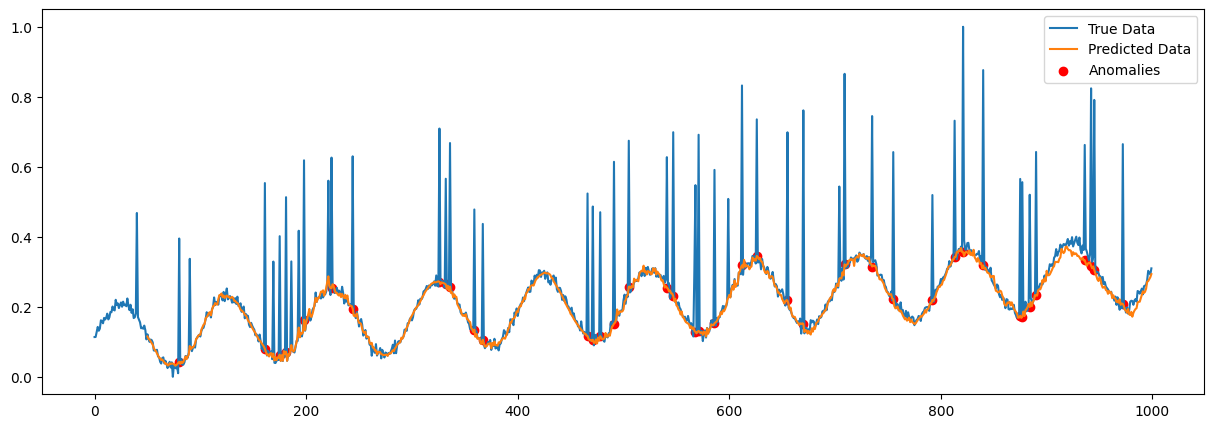

In [12]:
# Plot results
plt.figure(figsize=(15, 5))
plt.plot(scaled_values, label='True Data')
plt.plot(np.arange(look_back, len(predictions) + look_back), predictions, label='Predicted Data')
plt.scatter(anomalies + look_back, predictions[anomalies], color='red', label='Anomalies')
plt.legend()
plt.show()